In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def loadlist(array, name='file'):
    with open(name, "r") as f:
        for line in f:
            array.append(float(line.strip()))

### El Alto

In [17]:
pre = []
loadlist(pre, 'OAttenuation/ElAlto/pressure_00.txt')
pre = np.array(pre)
pre = pre / 100
pre = np.mean(pre)
dptemp = []
loadlist(dptemp, 'OAttenuation/ElAlto/2mdptemp_00.txt')
dptemp = np.array(dptemp)
dptemp = dptemp - 273.15
dptemp = np.mean(dptemp)
temp = []
loadlist(temp, 'OAttenuation/ElAlto/2mtemp_00.txt')
temp = np.array(temp)
temp = temp - 273.15
temp = np.mean(temp)

In [19]:
print(pre, dptemp, temp)

629.7962103909553 0.5334620757494518 7.393385943629059


In [102]:
a = 6.1121
b = 18.678
c = 257.14
d = 234.5
aux1 = (c * (b * d + c)) / (d * (temp + c))
aux2 = temp / d
aux3 = (-b * c) / (c + dptemp)
aux4 = - c / d
rh = 100 * np.exp(aux1 + aux2 + aux3 + aux4)
ef = 1 + (10 ** -4) * (7.2 + pre * (0.0320 + 5.9 * (10 ** -6) * (temp ** 2)))
es = ef * a * np.exp((temp * (b - temp / d))/(temp + c))
e = rh * es / 100 # Water vapour partial pressure (hPa)
rho = e * 216.7 / temp # Absolute Humidity
p = pre - e # Dry Air Pressure

In [50]:
wat_file = pd.read_csv('ITUFiles/wat676.csv')
oxy_file = pd.read_csv('ITUFiles/oxy676.csv')
fw = wat_file['fw'].to_numpy()
b1 = wat_file['b1'].to_numpy()
b2 = wat_file['b2'].to_numpy()
b3 = wat_file['b3'].to_numpy()
b4 = wat_file['b4'].to_numpy()
b5 = wat_file['b5'].to_numpy()
b6 = wat_file['b6'].to_numpy()
fo = oxy_file['fo'].to_numpy()
a1 = oxy_file['a1'].to_numpy()
a2 = oxy_file['a2'].to_numpy()
a3 = oxy_file['a3'].to_numpy()
a4 = oxy_file['a4'].to_numpy()
a5 = oxy_file['a5'].to_numpy()
a6 = oxy_file['a6'].to_numpy()

In [52]:
def itu676(f, p, rho, T):
    # p: dry air presure (hPa)
    # e: water vapour partial pressure (hPa)
    # T: Temperature (K)
    theta = 300/T
    e = (rho*T)/216.7
    So = a1 * (1e-7) * p * (theta**3) * np.exp(a2 * (1 - theta))
    Sw = b1 * (1e-1) * e * (theta**3.5) * np.exp(b2 * (1 - theta))
    deltao = (a5 + a6 * theta) * (1e-4) * (p + e) * (theta**0.8)
    deltaw = 0
    deltafo_wd = a3 * (1e-4) * (p * (theta**(0.8 - a4)) + 1.1 * e * theta)
    deltafw_wd = b3 * (1e-4) * (p * (theta**b4) + b5 * e * (theta**b6))
    deltafo = np.sqrt(deltafo_wd**2 + 2.25e-6)
    deltafw = 0.535 * deltafw_wd + np.sqrt((0.217 * deltafw_wd**2) + (2.1316e-12 * (fw**2))/(theta))
    Fo = ((f)/(fo)) * (((deltafo - deltao * (fo - f))/(deltafo**2 + (fo - f)**2))+((deltafo - deltao * (fo + f))/(deltafo**2 + (fo + f)**2)))
    Fw = ((f)/(fw)) * (((deltafw - deltaw * (fw - f))/(deltafw**2 + (fw - f)**2))+((deltafw - deltaw * (fw + f))/(deltafw**2 + (fw + f)**2)))
    d = (5.6e-4) * (p + e) * (theta**0.8)
    N2Df = f * p * theta**2 * (((6.14e-5)/(d * (1+(f/d)**2)))+((1.4e-12 * p * theta**1.5)/(1 + 1.9e-5 * f**1.5)))
    N2f = sum(Fo * So) + sum(Fw * Sw) + N2Df
    y = 0.182 * f * N2f
    ywv = 0.182 * f * sum(Fw * Sw)
    yox = 0.182 * f * (sum(Fo * So) + N2Df)
    return y, ywv, yox

In [103]:
print('p=', p)
print('e=', e)
print('T=', temp)

p= 623.4256247863557
e= 6.370585604599578
T= 7.393385943629059


In [92]:
def calc_ho(f, p, e, T):
    ci = np.array([0.1597, 0.1066, 0.1325, 0.1242, 0.0938, 0.1448, 0.1374])
    fi = np.array([118.750334, 368.498246, 424.76302, 487.249273, 715.392902, 773.83949, 834.145546])
    rp = (p + e) / 1013.25
    t3 = (0.0114 * f)/(1 + 0.14 * (rp ** -2.6)) * (15.02 * f * f - 1353 * f + 5.333e4)/((f ** 3)- 151.3 * f * f + 9629 * f - 6803)
    t1 = (5.104 / (1 + 0.066 * rp ** -2.3)) * np.exp(-((f - 59.7)/(2.87 + 12.4 * np.exp(-7.9 * rp))) ** 2)
    t2 = np.sum((ci * np.exp(2.12 * rp))/((f - fi) ** 2 + 0.025 * np.exp(2.2 * rp)))
    A = 0.7832 + 0.00709 * T
    ho = (6.1 * A * (1 + t1 + t2 + t3)) / (1 + 0.17 * rp ** -1.1)
    return ho
calc_ho(20, p, e, temp)

4.109020928626165

In [99]:
# 20 GHz
freq = 20
ktemp = temp + 273.15
yox = itu676(freq, p, rho, ktemp)[2]
ho = calc_ho(freq, p, e, temp)
oxat_20 = yox * ho
print('Oxygen Attenuation 20 GHz', oxat_20)
# 40 GHz
freq = 40
yox = itu676(freq, p, rho, ktemp)[2]
ho = calc_ho(freq, p, e, temp)
oxat_40 = yox * ho
print('Oxygen Attenuation 40 GHz', oxat_40)
# 50 GHz
freq = 50
yox = itu676(freq, p, rho, ktemp)[2]
ho = calc_ho(freq, p, e, temp)
oxat_50 = yox * ho
print('Oxygen Attenuation 50 GHz', oxat_50)
# 75 GHz
freq = 75
yox = itu676(freq, p, rho, ktemp)[2]
ho = calc_ho(freq, p, e, temp)
oxat_75 = yox * ho
print('Oxygen Attenuation 75 GHz', oxat_75)

Oxygen Attenuation 20 GHz 0.027690613071882867
Oxygen Attenuation 40 GHz 0.12488474985189597
Oxygen Attenuation 50 GHz 0.6734767928328286
Oxygen Attenuation 75 GHz 0.32861241683368425


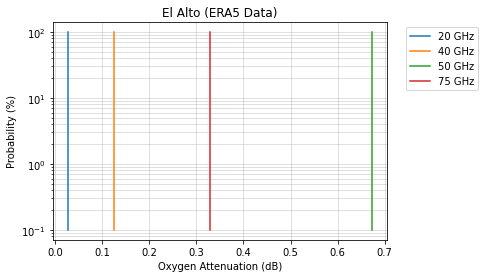

In [146]:
prob_nom = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 60, 70, 80, 90, 95, 99]
moxat_20 = [oxat_20] * 18
moxat_40 = [oxat_40] * 18
moxat_50 = [oxat_50] * 18
moxat_75 = [oxat_75] * 18

plt.semilogy(moxat_20, prob_nom, label = '20 GHz')
plt.semilogy(moxat_40, prob_nom, label = '40 GHz')
plt.semilogy(moxat_50, prob_nom, label = '50 GHz')
plt.semilogy(moxat_75, prob_nom, label = '75 GHz')
plt.grid(True, which="both", alpha=0.5)
plt.title('El Alto (ERA5 Data)')
plt.xlabel('Oxygen Attenuation (dB)')
plt.ylabel('Probability (%)')
plt.legend(bbox_to_anchor=(1.04,1), loc='best')
plt.show()

### La Guardia

In [147]:
pre = []
loadlist(pre, 'OAttenuation/LaGuardia/pressure_00.txt')
pre = np.array(pre)
pre = pre / 100
pre = np.mean(pre)
dptemp = []
loadlist(dptemp, 'OAttenuation/LaGuardia/2mdptemp_00.txt')
dptemp = np.array(dptemp)
dptemp = dptemp - 273.15
dptemp = np.mean(dptemp)
temp = []
loadlist(temp, 'OAttenuation/LaGuardia/2mtemp_00.txt')
temp = np.array(temp)
temp = temp - 273.15
temp = np.mean(temp)

In [148]:
print(pre, dptemp, temp)

944.1736940747514 17.63715930952375 22.683204543011097


In [149]:
a = 6.1121
b = 18.678
c = 257.14
d = 234.5
aux1 = (c * (b * d + c)) / (d * (temp + c))
aux2 = temp / d
aux3 = (-b * c) / (c + dptemp)
aux4 = - c / d
rh = 100 * np.exp(aux1 + aux2 + aux3 + aux4)
ef = 1 + (10 ** -4) * (7.2 + pre * (0.0320 + 5.9 * (10 ** -6) * (temp ** 2)))
es = ef * a * np.exp((temp * (b - temp / d))/(temp + c))
e = rh * es / 100 # Water vapour partial pressure (hPa)
rho = e * 216.7 / temp # Absolute Humidity
p = pre - e # Dry Air Pressure

In [150]:
# 20 GHz
freq = 20
ktemp = temp + 273.15
yox = itu676(freq, p, rho, ktemp)[2]
ho = calc_ho(freq, p, e, temp)
oxat_20 = yox * ho
print('Oxygen Attenuation 20 GHz', oxat_20)
# 40 GHz
freq = 40
yox = itu676(freq, p, rho, ktemp)[2]
ho = calc_ho(freq, p, e, temp)
oxat_40 = yox * ho
print('Oxygen Attenuation 40 GHz', oxat_40)
# 50 GHz
freq = 50
yox = itu676(freq, p, rho, ktemp)[2]
ho = calc_ho(freq, p, e, temp)
oxat_50 = yox * ho
print('Oxygen Attenuation 50 GHz', oxat_50)
# 75 GHz
freq = 75
yox = itu676(freq, p, rho, ktemp)[2]
ho = calc_ho(freq, p, e, temp)
oxat_75 = yox * ho
print('Oxygen Attenuation 75 GHz', oxat_75)

Oxygen Attenuation 20 GHz 0.059924908605858085
Oxygen Attenuation 40 GHz 0.2669096304363052
Oxygen Attenuation 50 GHz 1.4596087522131702
Oxygen Attenuation 75 GHz 0.6902603782976784


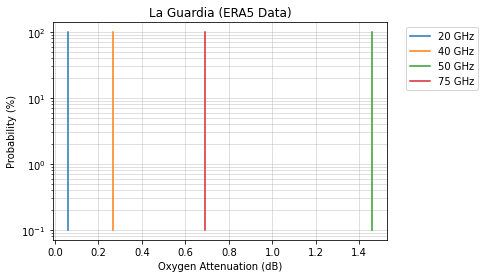

In [151]:
prob_nom = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 60, 70, 80, 90, 95, 99]
moxat_20 = [oxat_20] * 18
moxat_40 = [oxat_40] * 18
moxat_50 = [oxat_50] * 18
moxat_75 = [oxat_75] * 18

plt.semilogy(moxat_20, prob_nom, label = '20 GHz')
plt.semilogy(moxat_40, prob_nom, label = '40 GHz')
plt.semilogy(moxat_50, prob_nom, label = '50 GHz')
plt.semilogy(moxat_75, prob_nom, label = '75 GHz')
plt.grid(True, which="both", alpha=0.5)
plt.title('La Guardia (ERA5 Data)')
plt.xlabel('Oxygen Attenuation (dB)')
plt.ylabel('Probability (%)')
plt.legend(bbox_to_anchor=(1.04,1), loc='best')
plt.show()